In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# python implement of RTM on a two-layer heterogeneous theoretical model.

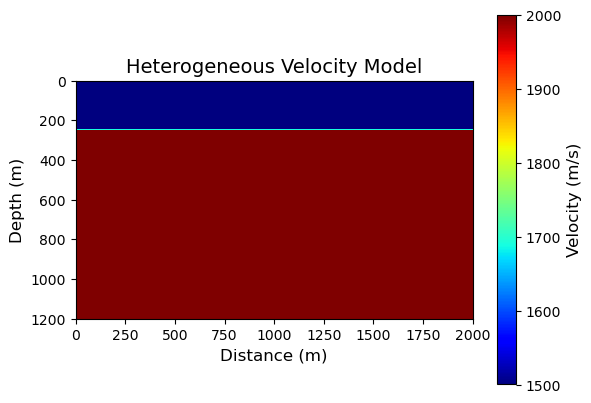

In [2]:
## . . Define spatial grid
Lx,Ly = 2000,1200           # . . lengths (m)
nx,ny = 401,241             # . . Number of points in discretization
dx,dy = Lx/(nx-1),Ly/(ny-1) # . . Discretization intervals

## . . Create velocity function
v = np.zeros((nx,ny))+1500
v[:,50:]=2000

plt.figure()
plt.imshow(v.T,cmap='jet',extent=[0,Lx,Ly,0])
cbar=plt.colorbar()
cbar.set_label('Velocity (m/s)',fontsize=12)
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title('Heterogeneous Velocity Model',fontsize=14)
plt.show()

In [3]:
from pdesolver.hyperbolic_hetero import awe_2d_explicit_solver_heterogeneous_8th_order, awe_2d_heterogeneous_8th_order_data_time_reverse

## . . Init wavefields on spatial grid
UUo = np.zeros((nx,ny))
UUm = np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 800                     # . . Number of time steps
dt = CC*dx/np.max(v)         # . . Define dt based on Courant
t  = np.linspace(0,(nt-1)*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))
shot_num = 10
sx = np.linspace(0, nx * dx, shot_num + 2)[1:-1]
sy = 25

In [4]:
from tqdm.notebook import tqdm
img = np.zeros((nx, ny))
for iter in tqdm(range(shot_num)): 
    fff = np.zeros((nx,ny,nt))
    for it in range(nt):
        tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx[iter],sy) #calc solution at n+1
        fff[:,:,it]=tmp  ## save solution vector
        UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
        UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

    ## . . Create velocity function
    v = np.zeros((nx,ny))+1500
    v[:,50:]=2000

    ## . . Init wavefields on spatial grid
    UUo = np.zeros((nx,ny))
    UUm = np.zeros((nx,ny))

    ## Time stepping parameters
    CC = 0.5                     # . . Courant #
    nt = 800                     # . . Number of time steps
    dt = CC*dx/np.max(v)         # . . Define dt based on Courant
    t  = np.linspace(0,nt*dt,nt) # . . Time lin
    t0 = 0.05                    # . . Wavelet shift

    ## . . Define forcing function
    ss=0.01                      # . . sigma for Ricker wavelet

    ## . . Get the data from fff above
    data = fff[:,5,:]

    ## . . Define source location
    ry=25                        # . . receiver injection location in y (in physical m units)

    ## . . Total Solution space
    mmm = np.zeros((nx,ny,nt))

    ## . . Iterate over solution
    ## . . Note time reversal
    for it in range(nt-1,0,-1):
        tmp = awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dy,dt,v,data,it,ry) #calc solution at n+1
        mmm[:,:,nt-1-it]=tmp  ## save solution vector
        UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
        UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

    img += np.sum(fff*mmm[:,:,::-1], axis=2)

  0%|          | 0/10 [00:00<?, ?it/s]

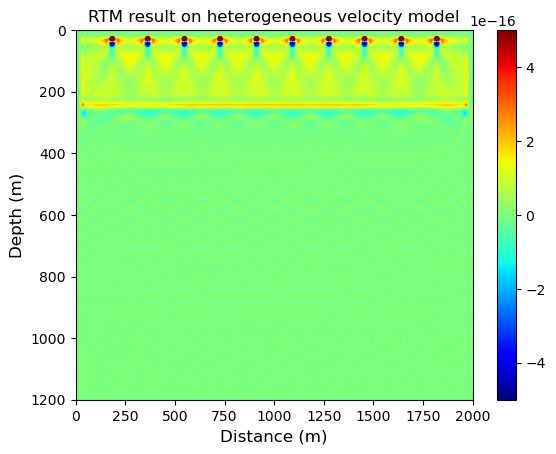

In [5]:
cx = np.array([-1,1])
plt.imshow(img.T, aspect='auto',cmap='jet',extent=[0,Lx,Ly,0])
plt.clim(cx * 5e-16)
plt.colorbar()
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title("RTM result on heterogeneous velocity model")
plt.savefig("RTM_theoretical_model.png")
plt.show()